
# 🌬️ WindDatas – Analyse technique des données de vent

Ce notebook constitue la **base technique robuste** pour l'analyse complète des données de vent dans le cadre du projet **WindDatas**.

Il a été conçu pour :
- être **modulaire et générique**, adapté à tous les sites présents dans `../data/`
- produire une **analyse rigoureuse, reproductible et documentée**
- servir de fondation pour des enrichissements futurs (page de garde, exports Word, ajout de modèles, etc.)

---

### 🔧 Structure du notebook :
1. Imports techniques et configuration
2. Sélection dynamique du site
3. Chargement automatisé des données
4. Vérification des colonnes critiques
5. Préparation et fusion des données
6. Analyses statistiques et visuelles détaillées
7. Détection des extrêmes
8. Ajustement de lois (Weibull / Gumbel)
9. Comparaison inter-sources


In [1]:

# ============================================================
# 📦 Imports globaux – tous en tête pour éviter les erreurs
# ============================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import radians
from scipy.stats import weibull_min, gumbel_r
import warnings

# 📉 Configuration visuelle
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = (10, 4)
sns.set_style("whitegrid")

# 🔇 Suppression des warnings
warnings.filterwarnings("ignore")


In [3]:
import os

try:
    base_data_path = os.path.abspath(os.path.join("..", "data"))
    available_sites = sorted([d for d in os.listdir(base_data_path) if os.path.isdir(os.path.join(base_data_path, d))])

    if not available_sites:
        raise Exception("Aucun dossier de site trouvé dans ../data")

    print("Sites disponibles :")
    for i, site in enumerate(available_sites):
        print(f"{i+1}. {site}")

    index = int(input("Entrez le numéro du site à analyser : ")) - 1

    site_name = available_sites[index]
    data_path = os.path.join(base_data_path, site_name)

    print(f"[✅] Site sélectionné : {site_name}")
    print(f"[📁] Chemin des données : {data_path}")

except Exception as e:
    print(f"[❌] Erreur dans la sélection du site : {e}")


Sites disponibles :
1. 0ld
2. WFR001_PIOLENC
3. WFR006_CARBONNE
4. WFR049_SALLES_SUR_GARONNE
5. WFR066_GROILLONS
6. WFR070_MADONE
7. WFR090_MONPEZAT
8. WIL010_Nofar Pilot
9. WIL017_ASHDOT
10. WIL045_KFAR HAMACCABI (KHM)
11. WIN160_RUMSL
12. WIT001_PONTECORVO
13. WJP104_YAMAKURA
14. WLU001_DIFFERDANGE
15. WNL001_AZALEALAAN
16. WNL005_WATTCO (Pilot)
17. WNL006_ALPEN WATTCO = Maxima Bridge
18. WNL009_ENGIE POND HQ = Engie Zaandam
19. WNL024_BURGUM CENTRAL = Engie Burgum
20. WNL026_OOSTERHOF HOLFMAN
21. WNL031_VELDHUNTEN
22. WNL049_K3
23. WNL059_ZALTBOMMEL
24. WPT008_ALTO_RABAGAO
25. WPT016_SAO LUIS = Cegonha
26. WPT026_CUBA ESTE
27. WSE001_BOR
28. WTW059_CHANGBIN
29. WUK003_QE2
30. WUK013_SHEEPLANDS FARM
31. WUK025_GODLEY RESERVOIR
32. WUK027_KEENS FARM
33. WUK028_WOODLANE
34. WUK029_PARK FARM
35. WUK045_POLYBELL
36. WUK063_REEDERS RESERVOIR
Entrez le numéro du site à analyser : 9
[✅] Site sélectionné : WIL017_ASHDOT
[📁] Chemin des données : c:\Users\AdrienSALICIS\Ciel & Terre Internation

In [4]:

# ============================================================
# 📥 Chargement automatisé des fichiers CSV
# ============================================================

dataframes = {}
for file in os.listdir(data_path):
    if file.endswith(".csv"):
        key = file.replace(".csv", "")
        try:
            df = pd.read_csv(os.path.join(data_path, file))
            if "time" in df.columns:
                df["time"] = pd.to_datetime(df["time"])
            elif "date" in df.columns:
                df = df.rename(columns={"date": "time"})
                df["time"] = pd.to_datetime(df["time"])
            if "time" in df.columns:
                df = df.sort_values("time")
            dataframes[key] = df
            print(f"[✅] {key} chargé ({len(df)} lignes)")
        except Exception as e:
            print(f"[❌] Erreur lecture {file} : {e}")


[✅] era5_ASHDOT chargé (18264 lignes)
[✅] era5_daily_ASHDOT chargé (18264 lignes)
[✅] meteostat1_ASHDOT chargé (2346 lignes)
[✅] meteostat2_ASHDOT chargé (2357 lignes)
[✅] nasa_power_ASHDOT chargé (18264 lignes)
[✅] openmeteo_ASHDOT chargé (18264 lignes)
[✅] power_ASHDOT chargé (18264 lignes)
[✅] statistics_comparison_ASHDOT chargé (10 lignes)


In [5]:

# ============================================================
# 📍 Résumé du site et période couverte
# ============================================================

site_info = {
    "Nom du site": site_name,
    "Fichiers disponibles": list(dataframes.keys())
}

all_dates = []
for df in dataframes.values():
    if "time" in df.columns:
        all_dates.extend(df["time"].dropna().tolist())

if all_dates:
    start = min(all_dates).date()
    end = max(all_dates).date()
    site_info["Période d’étude"] = f"{start} → {end}"
else:
    site_info["Période d’étude"] = "Inconnue"

print("📌 Informations sur le site :\n")
for key, value in site_info.items():
    print(f"- {key} : {value}")


📌 Informations sur le site :

- Nom du site : WIL017_ASHDOT
- Fichiers disponibles : ['era5_ASHDOT', 'era5_daily_ASHDOT', 'meteostat1_ASHDOT', 'meteostat2_ASHDOT', 'nasa_power_ASHDOT', 'openmeteo_ASHDOT', 'power_ASHDOT', 'statistics_comparison_ASHDOT']
- Période d’étude : 1975-01-01 → 2025-01-01



## 📊 Analyse statistique des vitesses moyennes et rafales

Ce bloc calcule des statistiques de base pour chaque source de données disponible :  
- nombre de valeurs (`count`)
- moyenne (`mean`)
- écart-type (`std`)
- minimum et maximum
- quantiles à 5%, 25%, 50%, 75%, 95%

Ces indicateurs permettent d'évaluer la cohérence et la dispersion des données issues de chaque source météo.


In [8]:
# ============================================================
# 📊 Statistiques descriptives regroupées (moyenne du vent)
# ============================================================

stats_summary = {}
for name, df in dataframes.items():
    if "windspeed_mean" in df.columns:
        stats = df["windspeed_mean"].describe(percentiles=[.05, .25, .5, .75, .95])
        stats_summary[name] = stats

df_stats = pd.DataFrame(stats_summary).T[
    ["count", "mean", "std", "min", "5%", "25%", "50%", "75%", "95%", "max"]
]

# ✅ Mise en forme visuelle à 2 décimales uniquement à l'affichage
display(
    df_stats.style
    .format(precision=2)
    .set_caption("📊 Statistiques descriptives des vitesses moyennes")
)


,count,mean,std,min,5%,25%,50%,75%,95%,max
era5_ASHDOT,18264.00,3.50,0.96,1.28,1.98,2.73,3.57,4.20,4.94,8.97
era5_daily_ASHDOT,18264.00,3.50,0.96,1.28,1.98,2.73,3.57,4.20,4.94,8.97
meteostat1_ASHDOT,2346.00,10.81,4.07,1.40,4.72,7.80,10.80,13.30,17.40,31.60
meteostat2_ASHDOT,2357.00,8.84,4.14,1.50,3.40,5.80,8.20,11.30,16.10,34.30
nasa_power_ASHDOT,16072.00,2.30,0.53,0.96,1.54,1.92,2.26,2.61,3.21,6.24
openmeteo_ASHDOT,18264.00,6.33,1.76,1.40,4.00,5.10,6.10,7.20,9.50,20.40
power_ASHDOT,16072.00,2.30,0.53,0.96,1.54,1.92,2.26,2.61,3.21,6.24



## 📈 Histogrammes des vitesses moyennes du vent

Cette visualisation montre la distribution des vitesses moyennes par source, sous forme :
- d’histogramme (comptage ou densité)
- avec une courbe de densité lissée (KDE)

Cela permet de détecter des effets de seuil, des distributions asymétriques ou des valeurs aberrantes.


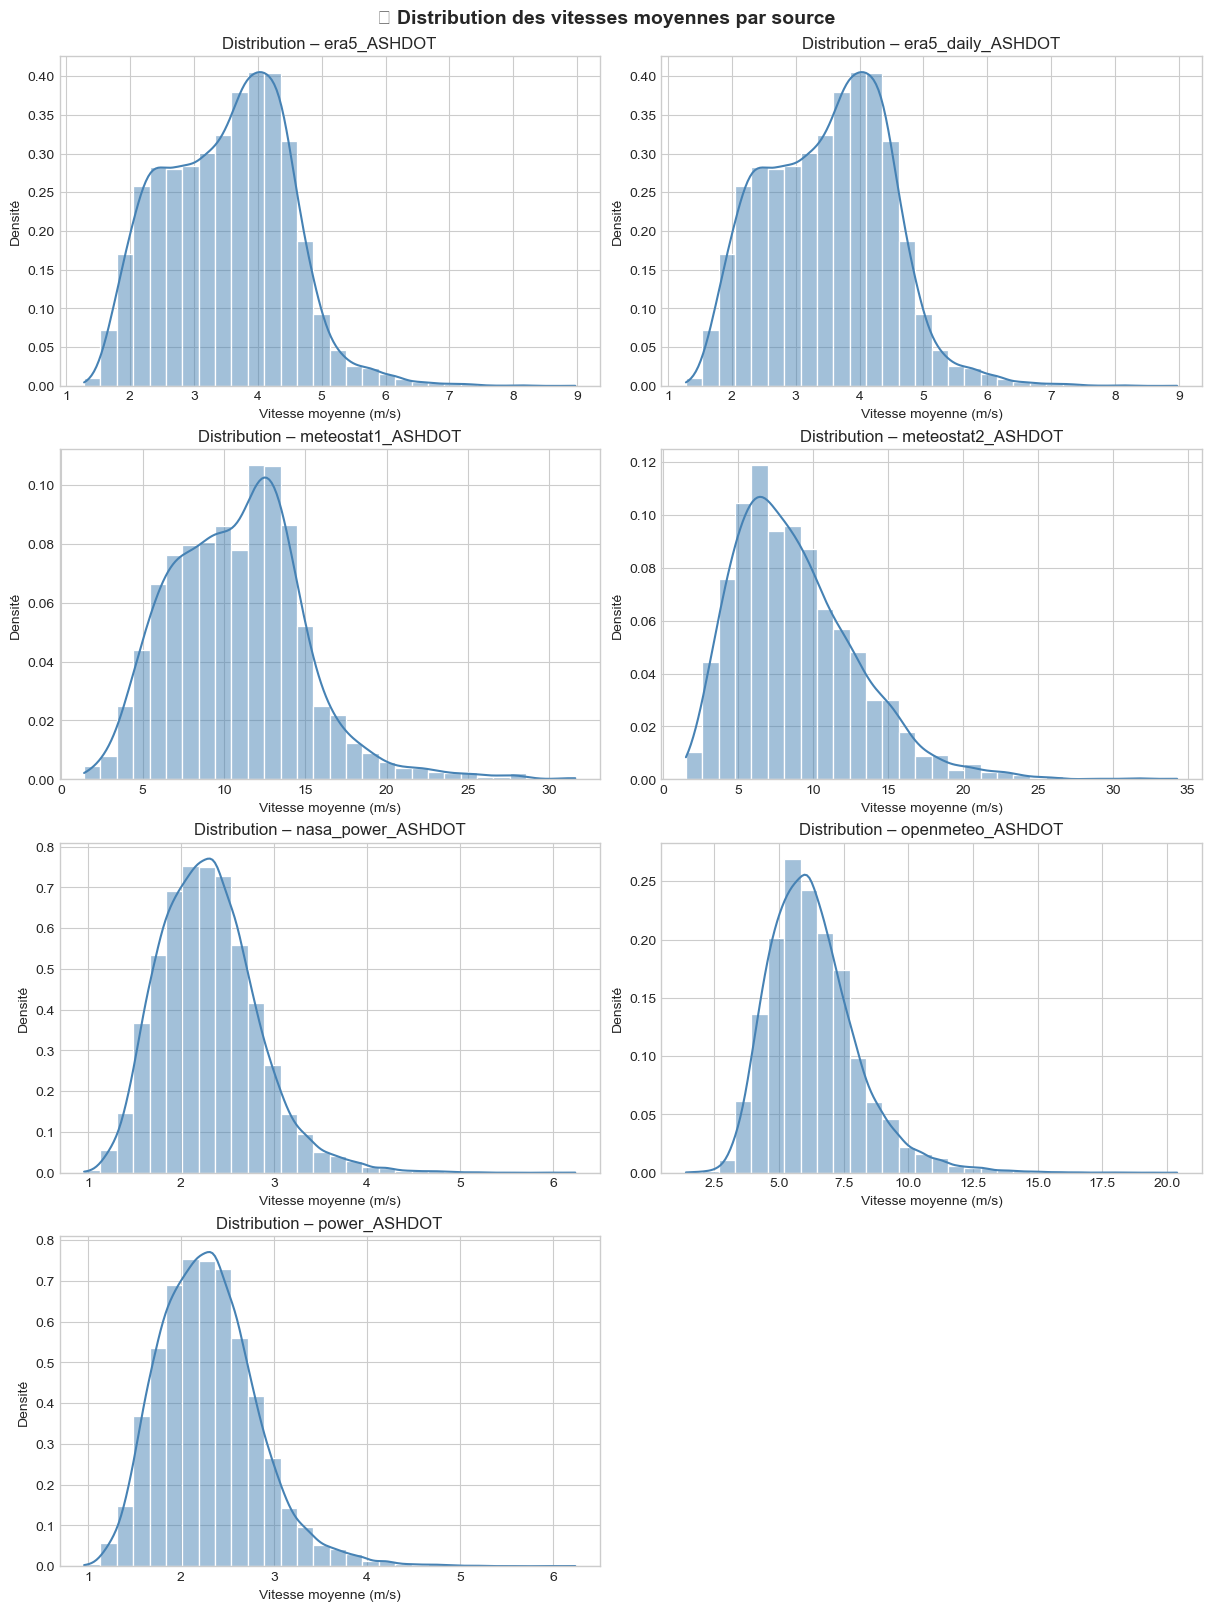

In [7]:
# ============================================================
# 📈 Histogrammes côte à côte par source (subplots)
# ============================================================

valid_sources = [(name, df["windspeed_mean"].dropna()) for name, df in dataframes.items()
                 if "windspeed_mean" in df.columns and len(df["windspeed_mean"].dropna()) >= 10]

n = len(valid_sources)
cols = 2
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), constrained_layout=True)
axes = axes.flatten() if n > 1 else [axes]

for i, (name, data) in enumerate(valid_sources):
    ax = axes[i]
    sns.histplot(data, bins=30, kde=True, stat='density', color='steelblue', ax=ax)
    ax.set_title(f"Distribution – {name}")
    ax.set_xlabel("Vitesse moyenne (m/s)")
    ax.set_ylabel("Densité")
    ax.grid(True)

# Supprimer les sous-graphiques inutiles si n est impair
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution des vitesses moyennes par source", fontsize=14, fontweight='bold')
plt.show()





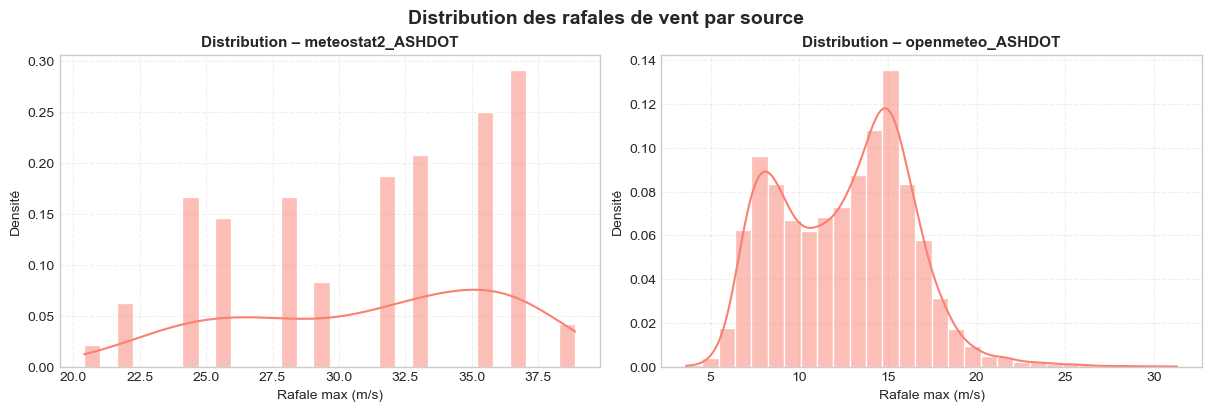

In [10]:
# ============================================================
# 💨 Histogrammes groupés – rafales de vent par source
# ============================================================

# 🔎 On sélectionne uniquement les sources avec assez de données de rafales
valid_gust_sources = [
    (name, df["windspeed_gust"].dropna())
    for name, df in dataframes.items()
    if "windspeed_gust" in df.columns and len(df["windspeed_gust"].dropna()) >= 10
]

# Configuration de la grille
n = len(valid_gust_sources)
cols = 2
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), constrained_layout=True)
axes = axes.flatten() if n > 1 else [axes]

# 📈 Tracé des histogrammes KDE
for i, (name, data) in enumerate(valid_gust_sources):
    ax = axes[i]
    sns.histplot(data, bins=30, kde=True, stat='density', color='salmon', ax=ax)
    ax.set_title(f"Distribution – {name}", fontsize=11, fontweight='bold')
    ax.set_xlabel("Rafale max (m/s)")
    ax.set_ylabel("Densité")
    ax.grid(True, linestyle='--', alpha=0.3)

# 🧼 Suppression des sous-graphiques vides
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 🧠 Titre global
plt.suptitle("Distribution des rafales de vent par source", fontsize=14, fontweight='bold')
plt.show()



## 📦 Comparaison visuelle – Boxplot

Le boxplot (ou boîte à moustaches) affiche :
- médiane (trait central)
- quartiles (boîte)
- valeurs extrêmes (points hors boîte)

Il est utilisé ici pour comparer visuellement les distributions de vitesses moyennes entre sources.


,outliers
meteostat1_BURGUM CENTRAL = Engie Burgum,384
power_BURGUM CENTRAL = Engie Burgum,294
nasa_power_BURGUM CENTRAL = Engie Burgum,294
openmeteo_BURGUM CENTRAL = Engie Burgum,282
era5_BURGUM CENTRAL = Engie Burgum,276
era5_daily_BURGUM CENTRAL = Engie Burgum,276
meteostat2_BURGUM CENTRAL = Engie Burgum,177


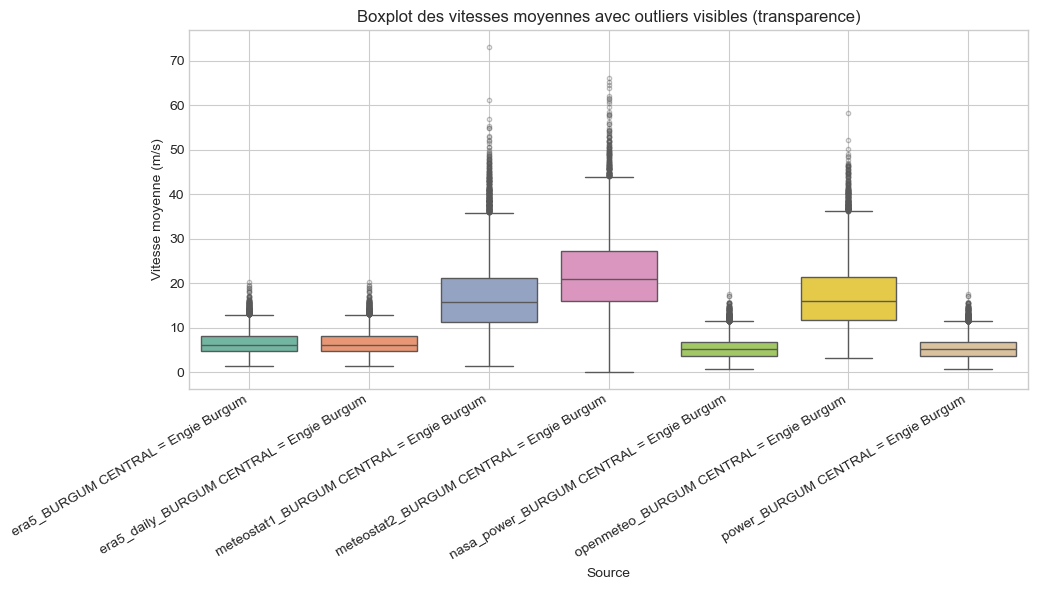

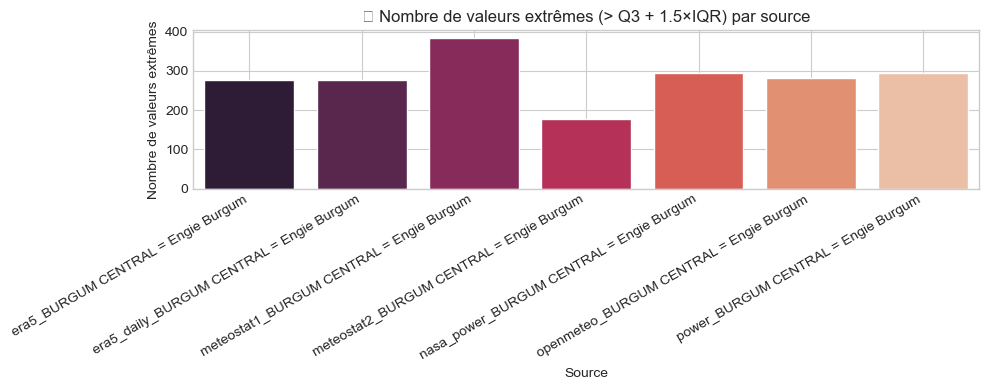

In [7]:
# ============================================================
# 📦 Boxplot avec outliers visibles + comptage des extrêmes
# ============================================================

# Fusionner les données
df_all_box = pd.concat([
    df.assign(source=name) for name, df in dataframes.items()
    if "windspeed_mean" in df.columns
], ignore_index=True)

# Détection des outliers par Tukey (Q3 + 1.5 × IQR)
outlier_counts = {}
for source in df_all_box["source"].unique():
    data = df_all_box[df_all_box["source"] == source]["windspeed_mean"].dropna()
    if len(data) < 10:
        continue
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr_val = q3 - q1
    seuil_sup = q3 + 1.5 * iqr_val
    outlier_counts[source] = (data > seuil_sup).sum()

# Afficher le tableau
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient="index", columns=["outliers"])
display(outlier_df.sort_values(by="outliers", ascending=False).style.set_caption("🔍 Nombre de valeurs extrêmes par source (> Q3 + 1.5×IQR)"))

# Afficher le boxplot avec outliers
fig, ax = plt.subplots(figsize=(max(10, len(outlier_counts) * 1.5), 6))
sns.boxplot(
    data=df_all_box,
    x="source",
    y="windspeed_mean",
    order=outlier_df.index,
    showfliers=True,
    flierprops=dict(marker='o', markersize=3, alpha=0.4),
    palette="Set2",
    ax=ax
)

ax.set_title("Boxplot des vitesses moyennes avec outliers visibles (transparence)")
ax.set_ylabel("Vitesse moyenne (m/s)")
ax.set_xlabel("Source")
plt.xticks(rotation=30, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔹 Histogramme du nombre de valeurs extrêmes
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(
    x=outlier_df.index,
    y=outlier_df["outliers"],
    palette="rocket",
    ax=ax
)
ax.set_title("📊 Nombre de valeurs extrêmes (> Q3 + 1.5×IQR) par source")
ax.set_ylabel("Nombre de valeurs extrêmes")
ax.set_xlabel("Source")
plt.xticks(rotation=30, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()




## 🚨 Détection des valeurs extrêmes (potentiellement aberrantes)

Certaines valeurs de vent très élevées peuvent correspondre à :
- des évènements météorologiques rares
- ou des erreurs de capteur / données mal encodées

Ce bloc détecte les valeurs supérieures à un seuil configurable (`50 m/s` par défaut), et les affiche classées par ordre décroissant.


In [8]:

# ============================================================
# 🚨 Détection des vitesses moyennes ou rafales extrêmes
# ============================================================

seuil = 50  # seuil paramétrable
for name, df in dataframes.items():
    for col in ["windspeed_gust", "windspeed_mean"]:
        if col in df.columns:
            extremes = df[df[col] > seuil]
            if len(extremes) > 0:
                print(f"⚠️ {len(extremes)} valeurs > {seuil} m/s pour {name} ({col})")
                display(extremes.sort_values(by=col, ascending=False)[["time", col]].head(10))


⚠️ 502 valeurs > 50 m/s pour meteostat1_BURGUM CENTRAL = Engie Burgum (windspeed_gust)


,time,windspeed_gust
16782,2022-02-18,119.0
16783,2022-02-19,115.0
16042,2020-02-09,115.0
16830,2022-04-07,101.0
17453,2023-12-21,97.0
17795,2024-11-27,97.0
17466,2024-01-03,97.0
17830,2025-01-01,96.0
17516,2024-02-22,96.0
17170,2023-03-13,94.0


⚠️ 13 valeurs > 50 m/s pour meteostat1_BURGUM CENTRAL = Engie Burgum (windspeed_mean)


,time,windspeed_mean
331,1976-01-03,73.2
5346,1990-02-26,61.3
348,1976-01-20,56.9
2840,1983-02-01,55.3
349,1976-01-21,54.9
2826,1983-01-18,54.9
3186,1984-01-17,53.2
16044,2020-02-11,52.8
1032,1977-12-24,52.2
6367,1993-01-24,51.9


⚠️ 450 valeurs > 50 m/s pour meteostat2_BURGUM CENTRAL = Engie Burgum (windspeed_gust)


,time,windspeed_gust
7639,2024-02-23,122.0
6906,2022-02-19,117.0
6905,2022-02-18,117.0
7638,2024-02-22,111.2
7588,2024-01-03,110.9
7576,2023-12-22,107.6
7917,2024-11-27,107.3
7548,2023-11-24,105.1
6904,2022-02-17,104.4
6907,2022-02-20,103.7


⚠️ 51 valeurs > 50 m/s pour meteostat2_BURGUM CENTRAL = Engie Burgum (windspeed_mean)


,time,windspeed_mean
6529,2021-02-07,66.2
4273,2013-12-06,65.3
1833,2006-11-01,64.5
2170,2007-11-09,63.9
3629,2012-01-05,62.1
5493,2018-03-17,61.7
5776,2019-01-08,61.4
5355,2017-10-29,60.9
4726,2015-03-31,60.6
7548,2023-11-24,59.7


⚠️ 150 valeurs > 50 m/s pour openmeteo_BURGUM CENTRAL = Engie Burgum (windspeed_gust)


,time,windspeed_gust
5504,1990-01-26,73.4
5503,1990-01-25,72.4
2953,1983-02-01,70.4
3300,1984-01-14,69.5
3301,1984-01-15,68.5
14180,2013-10-28,68.0
5535,1990-02-26,66.6
367,1976-01-03,66.1
6587,1993-01-13,65.2
9918,2002-02-26,61.8


⚠️ 3 valeurs > 50 m/s pour openmeteo_BURGUM CENTRAL = Engie Burgum (windspeed_mean)


,time,windspeed_mean
367,1976-01-03,58.2
5535,1990-02-26,52.3
6598,1993-01-24,50.3



## 📐 Ajustement de lois de probabilité : Weibull et Gumbel

Nous utilisons deux lois statistiques classiques pour modéliser les vitesses de vent :
- **Weibull** : souvent utilisée en ingénierie du vent (forme + échelle)
- **Gumbel** : spécialisée dans l’étude des maxima (vents extrêmes)

Ces courbes sont ajustées sur les données observées pour chaque source, puis comparées visuellement à l’histogramme empirique.


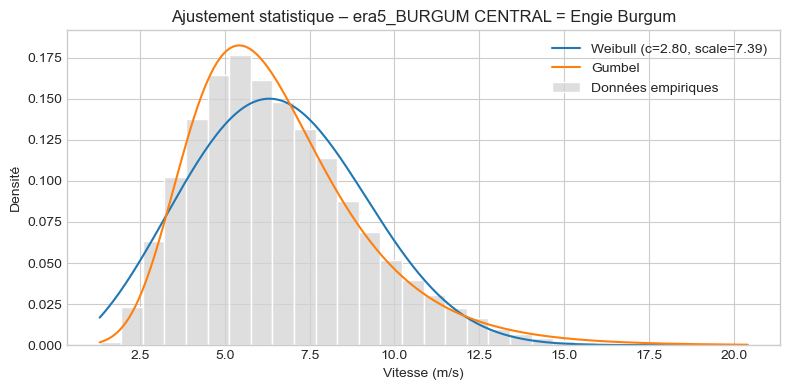

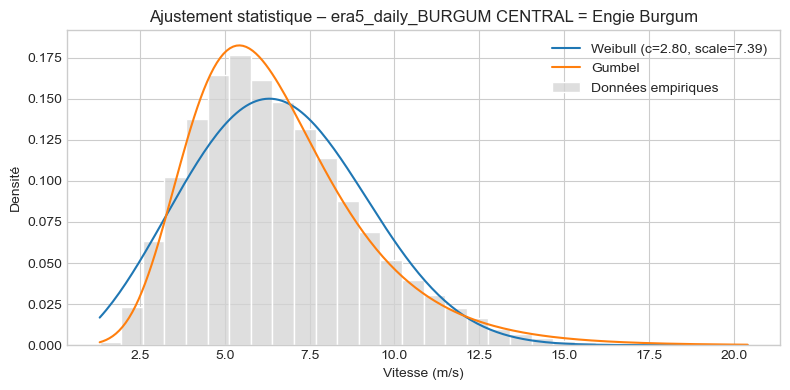

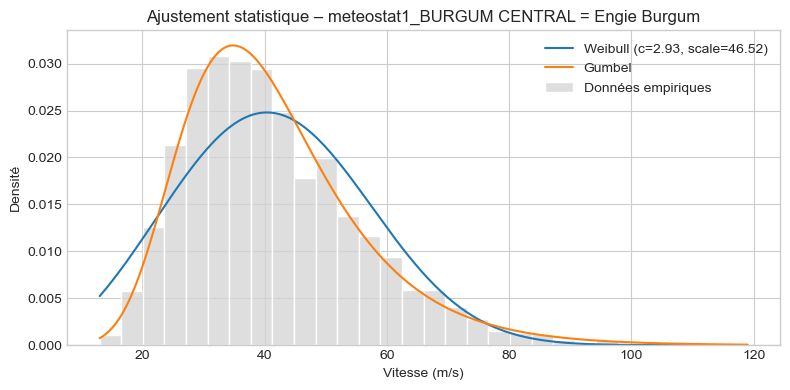

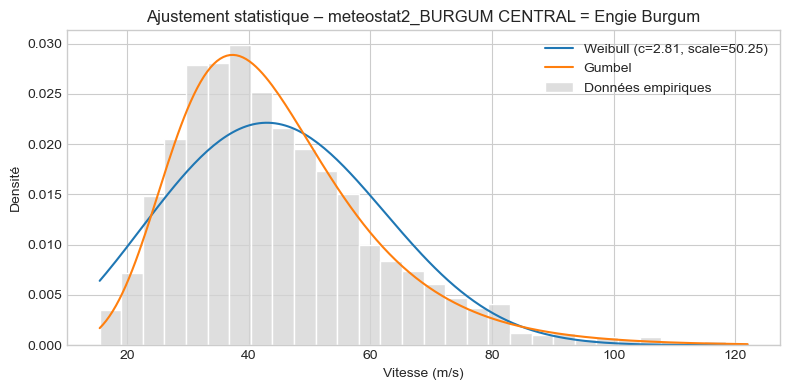

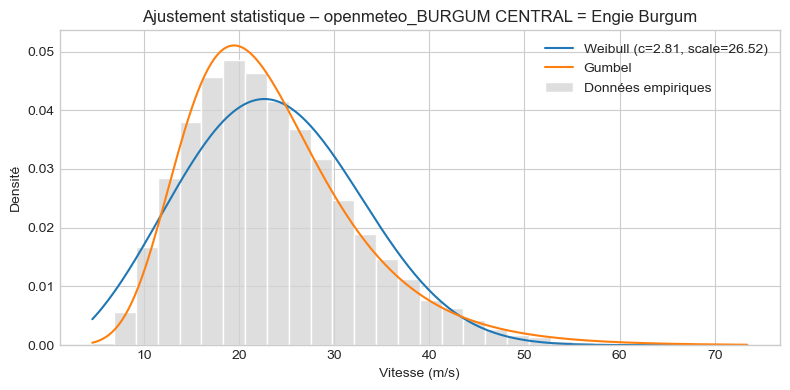

In [9]:

# ============================================================
# 📐 Ajustement de la loi de Weibull et Gumbel
# ============================================================

for name, df in dataframes.items():
    col = "windspeed_gust" if "windspeed_gust" in df.columns else "windspeed_mean"
    if col not in df.columns:
        continue

    data = df[col].dropna()
    if len(data) < 30:
        continue  # pas assez de données pour ajustement fiable

    plt.figure(figsize=(8, 4))
    sns.histplot(data, bins=30, stat='density', color='lightgray', label="Données empiriques")

    x_vals = np.linspace(data.min(), data.max(), 200)

    # Loi de Weibull (2 paramètres)
    c, loc, scale = weibull_min.fit(data, floc=0)
    weibull_pdf = weibull_min.pdf(x_vals, c, loc, scale)
    plt.plot(x_vals, weibull_pdf, label=f"Weibull (c={c:.2f}, scale={scale:.2f})")

    # Loi de Gumbel (maximum)
    loc_g, scale_g = gumbel_r.fit(data)
    gumbel_pdf = gumbel_r.pdf(x_vals, loc_g, scale_g)
    plt.plot(x_vals, gumbel_pdf, label="Gumbel")

    plt.title(f"Ajustement statistique – {name}")
    plt.xlabel("Vitesse (m/s)")
    plt.ylabel("Densité")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()



## 🔁 Comparaison croisée entre sources

Pour chaque paire de sources disponibles, nous comparons les valeurs disponibles en commun :
- Erreur absolue moyenne (MAE)
- Corrélation linéaire (Pearson)
- Nombre de jours communs

Les résultats sont affichés de manière synthétique et lisible.


In [10]:

# ============================================================
# 🔁 Comparaison croisée : MAE et Corrélation
# ============================================================

def compare_sources(df1, df2, label1, label2, threshold=15):
    # Détection colonne vitesse
    col1 = "windspeed_gust" if "windspeed_gust" in df1.columns else "windspeed_mean"
    col2 = "windspeed_gust" if "windspeed_gust" in df2.columns else "windspeed_mean"

    # Vérif existence colonnes avant rename
    if "time" not in df1.columns or col1 not in df1.columns:
        print(f"[⚠️] Colonnes manquantes dans {label1}")
        return None
    if "time" not in df2.columns or col2 not in df2.columns:
        print(f"[⚠️] Colonnes manquantes dans {label2}")
        return None

    # Renommage AVANT fusion
    df1_renamed = df1[["time", col1]].rename(columns={col1: label1})
    df2_renamed = df2[["time", col2]].rename(columns={col2: label2})

    # Fusion
    merged = pd.merge(df1_renamed, df2_renamed, on="time")
    if merged.empty:
        print(f"[⚠️] Aucune date commune entre {label1} et {label2}")
        return None

    mae = (merged[label1] - merged[label2]).abs().mean()
    corr = merged[label1].corr(merged[label2])
    return {
        "source_1": label1,
        "source_2": label2,
        "MAE": round(mae, 2),
        "corrélation": round(corr, 3),
        "nb_jours": len(merged)
    }


# Calcul et affichage des comparaisons croisées
results = []
keys = list(dataframes.keys())

for key in keys:
    print(f"📄 {key} → colonnes :", dataframes[key].columns.tolist())

for i in range(len(keys)):
    for j in range(i + 1, len(keys)):
        r = compare_sources(dataframes[keys[i]], dataframes[keys[j]], keys[i], keys[j])
        if r:
            results.append(r)

results_df = pd.DataFrame(results)
if not results_df.empty:
    display(results_df.sort_values(by="MAE"))
else:
    print("Aucune comparaison croisée valide.")


📄 era5_BURGUM CENTRAL = Engie Burgum → colonnes : ['time', 'windspeed_10m', 'windspeed_mean', 'wind_direction']
📄 era5_daily_BURGUM CENTRAL = Engie Burgum → colonnes : ['time', 'windspeed_10m', 'windspeed_mean', 'wind_direction']
📄 meteostat1_BURGUM CENTRAL = Engie Burgum → colonnes : ['time', 'windspeed_mean', 'windspeed_gust', 'wind_direction']
📄 meteostat2_BURGUM CENTRAL = Engie Burgum → colonnes : ['time', 'windspeed_mean', 'windspeed_gust', 'wind_direction']
📄 nasa_power_BURGUM CENTRAL = Engie Burgum → colonnes : ['time', 'windspeed_mean', 'windspeed_gust', 'wind_direction', 'u_component_10m', 'v_component_10m']
📄 openmeteo_BURGUM CENTRAL = Engie Burgum → colonnes : ['time', 'windspeed_gust', 'windspeed_mean', 'wind_direction']
📄 power_BURGUM CENTRAL = Engie Burgum → colonnes : ['time', 'windspeed_mean', 'windspeed_gust', 'wind_direction', 'u_component_10m', 'v_component_10m']
📄 statistics_comparison_BURGUM CENTRAL = Engie Burgum → colonnes : ['comparison', 'mean_meteostat1', 'mea

,source_1,source_2,MAE,corrélation,nb_jours
0,era5_BURGUM CENTRAL = Engie Burgum,era5_daily_BURGUM CENTRAL = Engie Burgum,0.00,1.000,18264
11,meteostat1_BURGUM CENTRAL = Engie Burgum,meteostat2_BURGUM CENTRAL = Engie Burgum,5.86,0.902,7899
9,era5_daily_BURGUM CENTRAL = Engie Burgum,openmeteo_BURGUM CENTRAL = Engie Burgum,17.03,0.986,18264
4,era5_BURGUM CENTRAL = Engie Burgum,openmeteo_BURGUM CENTRAL = Engie Burgum,17.03,0.986,18264
13,meteostat1_BURGUM CENTRAL = Engie Burgum,openmeteo_BURGUM CENTRAL = Engie Burgum,18.31,0.928,17831
16,meteostat2_BURGUM CENTRAL = Engie Burgum,openmeteo_BURGUM CENTRAL = Engie Burgum,21.66,0.872,7953
6,era5_daily_BURGUM CENTRAL = Engie Burgum,meteostat1_BURGUM CENTRAL = Engie Burgum,34.94,0.926,17831
1,era5_BURGUM CENTRAL = Engie Burgum,meteostat1_BURGUM CENTRAL = Engie Burgum,34.94,0.926,17831
7,era5_daily_BURGUM CENTRAL = Engie Burgum,meteostat2_BURGUM CENTRAL = Engie Burgum,38.23,0.886,7953
2,era5_BURGUM CENTRAL = Engie Burgum,meteostat2_BURGUM CENTRAL = Engie Burgum,38.23,0.886,7953


In [11]:

# 📊 Qualité des données – récapitulatif sécurisé
for name, df in dataframes.items():
    if "time" not in df.columns:
        print(f"\n⚠️ {name} ignoré (pas de colonne 'time')")
        continue

    print(f"\n🔍 {name}")
    print(f"- Nombre de jours : {len(df)}")
    print(f"- Plage : {df['time'].min().date()} → {df['time'].max().date()}")
    
    if "windspeed_mean" in df.columns:
        taux_nan = df["windspeed_mean"].isna().mean()
        print(f"- Taux de valeurs manquantes (windspeed_mean) : {taux_nan:.2%}")
    else:
        print("- Colonne 'windspeed_mean' absente")



🔍 era5_BURGUM CENTRAL = Engie Burgum
- Nombre de jours : 18264
- Plage : 1975-01-01 → 2025-01-01
- Taux de valeurs manquantes (windspeed_mean) : 0.00%

🔍 era5_daily_BURGUM CENTRAL = Engie Burgum
- Nombre de jours : 18264
- Plage : 1975-01-01 → 2025-01-01
- Taux de valeurs manquantes (windspeed_mean) : 0.00%

🔍 meteostat1_BURGUM CENTRAL = Engie Burgum
- Nombre de jours : 17831
- Plage : 1975-01-01 → 2025-01-01
- Taux de valeurs manquantes (windspeed_mean) : 0.48%

🔍 meteostat2_BURGUM CENTRAL = Engie Burgum
- Nombre de jours : 7953
- Plage : 2000-10-05 → 2025-01-01
- Taux de valeurs manquantes (windspeed_mean) : 0.38%

🔍 nasa_power_BURGUM CENTRAL = Engie Burgum
- Nombre de jours : 18264
- Plage : 1975-01-01 → 2025-01-01
- Taux de valeurs manquantes (windspeed_mean) : 12.00%

🔍 openmeteo_BURGUM CENTRAL = Engie Burgum
- Nombre de jours : 18264
- Plage : 1975-01-01 → 2025-01-01
- Taux de valeurs manquantes (windspeed_mean) : 0.00%

🔍 power_BURGUM CENTRAL = Engie Burgum
- Nombre de jours : 

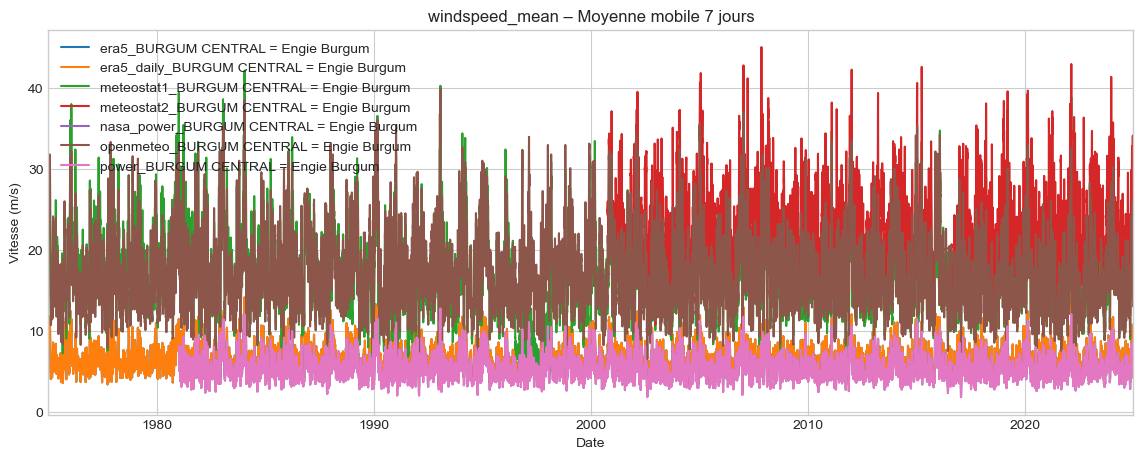

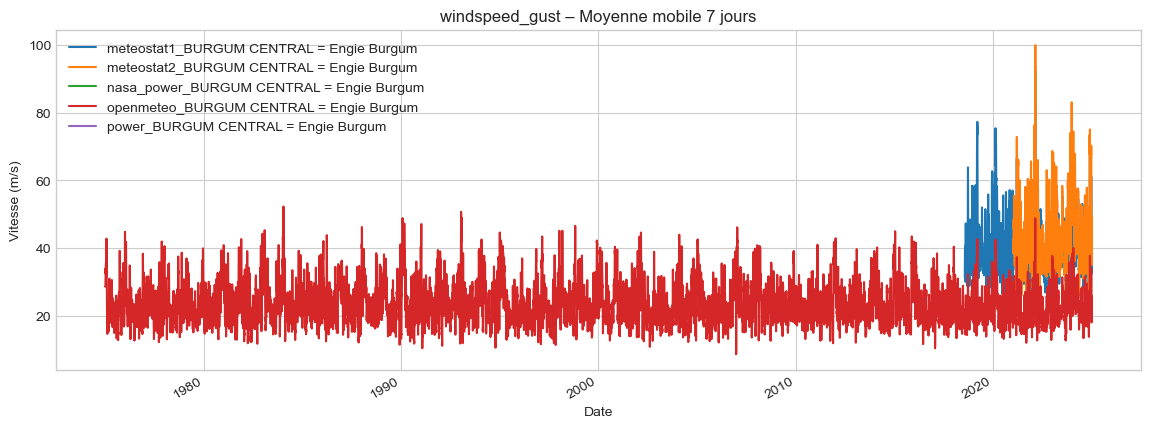

In [12]:

# 📈 Courbes lissées des vitesses (rolling mean 7 jours)
for var in ["windspeed_mean", "windspeed_gust"]:
    plt.figure(figsize=(14,5))
    for name, df in dataframes.items():
        if var in df.columns:
            df.set_index("time")[var].rolling(7).mean().plot(label=name)
    plt.title(f"{var} – Moyenne mobile 7 jours")
    plt.xlabel("Date")
    plt.ylabel("Vitesse (m/s)")
    plt.legend()
    plt.show()


In [13]:

# 💥 Analyse des jours à vents extrêmes (> 25 m/s)
for name, df in dataframes.items():
    if "windspeed_gust" in df.columns:
        extremes = df[df["windspeed_gust"] > 25]
        print(f"\n💥 {name} – {len(extremes)} jours > 25 m/s")
        display(extremes[["time", "windspeed_gust"]].head())



💥 meteostat1_BURGUM CENTRAL = Engie Burgum – 2082 jours > 25 m/s


,time,windspeed_gust
15474,2018-07-21,36.0
15475,2018-07-22,29.0
15477,2018-07-24,29.0
15478,2018-07-25,29.6
15479,2018-07-26,32.0



💥 meteostat2_BURGUM CENTRAL = Engie Burgum – 1341 jours > 25 m/s


,time,windspeed_gust
6494,2021-01-03,54.7
6495,2021-01-04,62.6
6496,2021-01-05,57.2
6497,2021-01-06,45.4
6499,2021-01-08,28.1



💥 nasa_power_BURGUM CENTRAL = Engie Burgum – 0 jours > 25 m/s


,time,windspeed_gust



💥 openmeteo_BURGUM CENTRAL = Engie Burgum – 7045 jours > 25 m/s


,time,windspeed_gust
0,1975-01-01,26.3
3,1975-01-04,29.8
4,1975-01-05,33.2
5,1975-01-06,41.2
6,1975-01-07,31.4



💥 power_BURGUM CENTRAL = Engie Burgum – 0 jours > 25 m/s


,time,windspeed_gust


In [14]:

# 📐 Ajustement de la loi de Weibull
from scipy.stats import weibull_min

for name, df in dataframes.items():
    if "windspeed_mean" in df.columns:
        data = df["windspeed_mean"].dropna()
        if not data.empty:
            params = weibull_min.fit(data, floc=0)
            print(f"Weibull – {name} : shape={params[0]:.2f}, scale={params[2]:.2f}")


Weibull – era5_BURGUM CENTRAL = Engie Burgum : shape=2.80, scale=7.39
Weibull – era5_daily_BURGUM CENTRAL = Engie Burgum : shape=2.80, scale=7.39
Weibull – meteostat1_BURGUM CENTRAL = Engie Burgum : shape=2.36, scale=19.21
Weibull – meteostat2_BURGUM CENTRAL = Engie Burgum : shape=2.70, scale=25.25
Weibull – nasa_power_BURGUM CENTRAL = Engie Burgum : shape=2.51, scale=6.21
Weibull – openmeteo_BURGUM CENTRAL = Engie Burgum : shape=2.52, scale=19.38
Weibull – power_BURGUM CENTRAL = Engie Burgum : shape=2.51, scale=6.21


In [15]:

# 📎 Chargement des statistiques de comparaison inter-sources
import glob

csv_stats = glob.glob(os.path.join(data_path, "statistics_comparison_*.csv"))
if csv_stats:
    df_stats = pd.read_csv(csv_stats[0])
    display(df_stats.style.background_gradient(axis=0, cmap="Blues"))
else:
    print("Aucune comparaison statistique trouvée.")


,comparison,mean_meteostat1,mean_meteostat2,mean_diff,mae,correlation,std_meteostat1,std_meteostat2,max_meteostat1,max_meteostat2,min_meteostat1,min_meteostat2,count,extreme_days_meteostat1,extreme_days_meteostat2,mean_dir_meteostat1,mean_dir_meteostat2,dir_diff_abs,mean_openmeteo,std_openmeteo,max_openmeteo,min_openmeteo,extreme_days_openmeteo,mean_dir_openmeteo,mean_nasa_power,std_nasa_power,max_nasa_power,min_nasa_power,extreme_days_nasa_power,mean_dir_nasa_power,mean_era5,std_era5,max_era5,min_era5,extreme_days_era5,mean_dir_era5
0,meteostat1 vs meteostat2,41.442000,44.776000,3.334000,5.862000,0.902000,14.721000,16.560000,119.000000,122.000000,13.000000,15.500000,7899,2326.000000,1445.000000,194.160000,192.360000,1.800000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,meteostat1 vs openmeteo,41.532000,nan,-17.903000,18.314000,0.928000,14.741000,nan,119.000000,nan,13.000000,nan,17831,2348.000000,nan,194.160000,nan,2.530000,23.629000,8.879000,73.400000,4.600000,14896.000000,196.690000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,meteostat1 vs nasa_power,41.532000,nan,nan,nan,nan,14.741000,nan,119.000000,nan,13.000000,nan,17831,2348.000000,nan,194.160000,nan,6.610000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,200.770000,nan,nan,nan,nan,nan,nan
3,meteostat1 vs era5,41.532000,nan,-34.947000,34.937000,0.926000,14.741000,nan,119.000000,nan,13.000000,nan,17831,2348.000000,nan,194.160000,nan,2.090000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,6.585000,2.484000,20.403000,1.315000,68.000000,196.250000
4,meteostat2 vs openmeteo,nan,44.776000,-21.519000,21.659000,0.872000,nan,16.560000,nan,122.000000,nan,15.500000,7953,nan,1445.000000,nan,192.360000,4.330000,23.257000,8.520000,68.000000,5.100000,6648.000000,196.690000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,meteostat2 vs nasa_power,nan,44.776000,nan,nan,nan,nan,16.560000,nan,122.000000,nan,15.500000,7953,nan,1445.000000,nan,192.360000,8.410000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,200.770000,nan,nan,nan,nan,nan,nan
6,meteostat2 vs era5,nan,44.776000,-38.266000,38.228000,0.886000,nan,16.560000,nan,122.000000,nan,15.500000,7953,nan,1445.000000,nan,192.360000,3.890000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,6.510000,2.409000,19.009000,1.436000,28.000000,196.250000
7,openmeteo vs nasa_power,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,18264,nan,nan,nan,nan,4.080000,23.605000,8.885000,73.400000,4.600000,15239.000000,196.690000,nan,nan,nan,nan,0.000000,200.770000,nan,nan,nan,nan,nan,nan
8,openmeteo vs era5,nan,nan,-17.027000,17.027000,0.986000,nan,nan,nan,nan,nan,nan,18264,nan,nan,nan,nan,0.440000,23.605000,8.885000,73.400000,4.600000,15239.000000,196.690000,nan,nan,nan,nan,nan,nan,6.578000,2.485000,20.403000,1.315000,70.000000,196.250000
9,nasa_power vs era5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,18264,nan,nan,nan,nan,4.520000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,200.770000,6.578000,2.485000,20.403000,1.315000,70.000000,196.250000
